In [1]:
# import thư viện
import gzip
import json
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')  # bộ tách từ tiếng Anh
nltk.download('punkt_tab')  # phần mở rộng của nltk
from nltk.tokenize import word_tokenize
import numpy as np


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# 1 Đọc dữ Liệu văn bản từ file .gz
input_path = "../data/c4-train.00000-of-01024-30K.json.gz"
# đọc data từ input_path
texts = []
with gzip.open(input_path, 'rt', encoding='utf-8') as f:  # đọc file từ tệp nhị phân
    for line in f:
        try:
            obj = json.loads(line)  # đọc từng dòng json và chuyển về dict
            if 'text' in obj:
                texts.append(obj['text'])
        except Exception:
            continue

print(f"Đọc thành công {len(texts)} dòng văn bản.")


Đọc thành công 30000 dòng văn bản.


In [6]:
# 2 Tiền xử lý & tách từ
nltk.download('punkt', quiet=True)

# tách văn bản thành từng từ, chuyển hết về chữ thường, bỏ hết các dấu và số
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

sentences = [word_tokenize(clean_text(t)) for t in texts if isinstance(t, str)]
print(f"Tách thành {len(sentences)} câu.")


Tách thành 30000 câu.


In [7]:
# 3 Huấn Luyện mô hình Word2Vec
# đầu vào Là danh sách các câu sentences, số chiều của vecto Là 100,
# ngữ cảnh gồm 5 từ trước & sau,
# bỏ qua các từ xuất hiện 1 Lần, dùng 4 CPU song song để giảm thời gian huấn Luyện
print("Huấn luyện = Word2Vec")
model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Lấy danh sách các từ trong từ điển và ma trận có kích thước (số từ x 100)
words = list(model.wv.key_to_index.keys())
vectors = np.array([model.wv[w] for w in words])


Huấn luyện = Word2Vec


In [8]:
# 4 Giảm chiều (PCA + t-SNE)
n_show = min(500, len(words))
X = vectors[:n_show]
selected_words = words[:n_show]

print("Giảm chiều bằng PCA + t-SNE")
pca = PCA(n_components=50)  # giảm từ 100 xuống 50 chiều
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # giảm từ 50 xuống 2 chiều
X_tsne = tsne.fit_transform(X_pca)


Giảm chiều bằng PCA + t-SNE


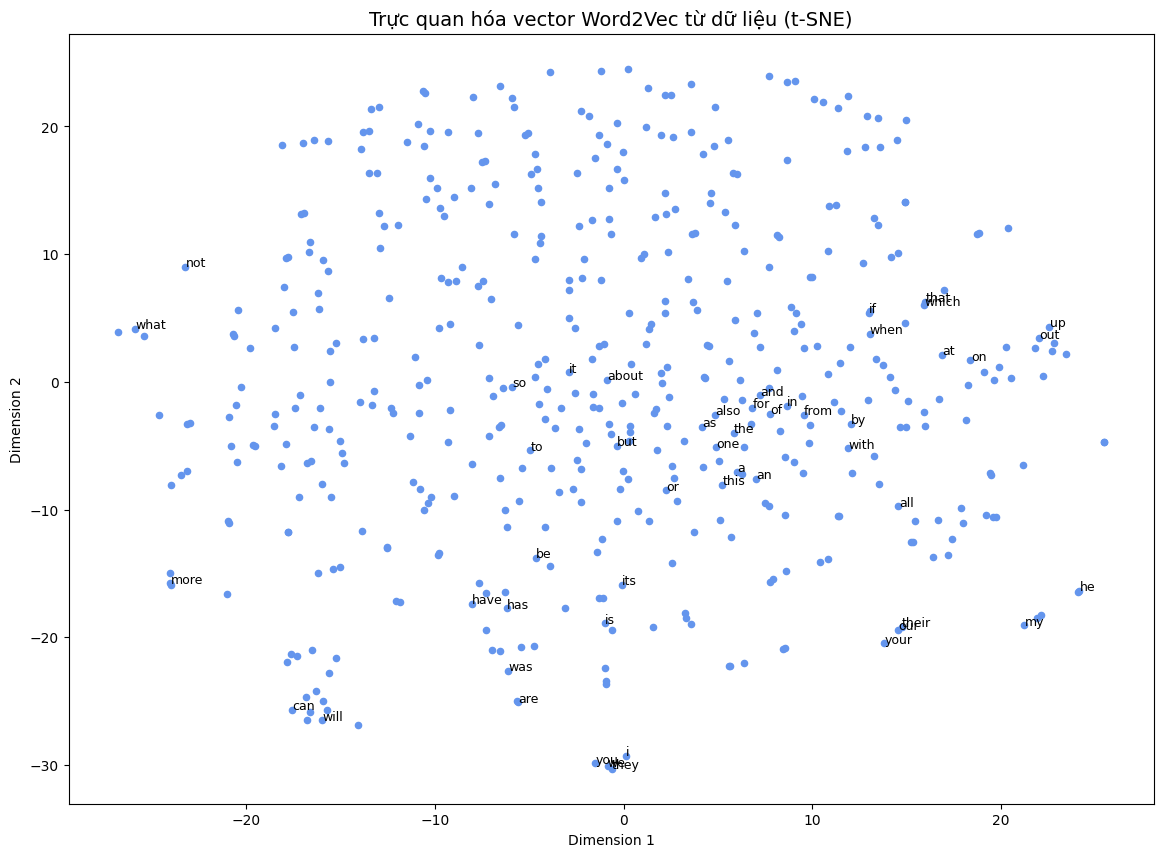

In [9]:
# 5 Trực quan hóa
plt.figure(figsize=(14, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=20, color='cornflowerblue')

for i, word in enumerate(selected_words[:50]):
    plt.text(X_tsne[i, 0]+0.02, X_tsne[i, 1]+0.02, word, fontsize=9)

plt.title("Trực quan hóa vector Word2Vec từ dữ liệu (t-SNE)", fontsize=14)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [10]:
# 6 Tìm từ tương đồng
target = np.random.choice(words)
print(f"\nTop 10 từ tương đồng với '{target}':")
for w, score in model.wv.most_similar(target, topn=10):
    print(f"{w:15s} : {score:.4f}")



Top 10 từ tương đồng với 'reapply':
dosing          : 0.7752
grafting        : 0.7707
sterile         : 0.7386
misalignment    : 0.7335
exogenous       : 0.7309
awcsl           : 0.7288
inhalation      : 0.7272
liposuction     : 0.7242
confirmatory    : 0.7231
anemia          : 0.7228


## 1 số đánh giá
Dữ liệu có 30.000 đoạn text. Đây là quy mô vừa đủ để học các mối quan hệ từ cơ bản, nhưng chưa đủ lớn để học ngữ nghĩa sâu.

Word2Vec là mô hình shallow (chỉ 1 lớp ẩn). Nó học nhanh, dễ hiểu, nhưng không bắt được ngữ cảnh dài hoặc đa nghĩa như BERT / GPT.

Với min_count=2 và vector_size=100, mô hình đủ để biểu diễn ngữ nghĩa cơ bản (ví dụ: "grill" gần "bbq"). Nhưng cần clean dữ liệu tốt và đa dạng chủ đề để vector chất lượng cao hơn.

Hiệu suất và tốc độ huấn luyện: rất nhanh – đặc biệt nhờ workers=4 và kích thước từ vựng nhỏ (~10k từ). Huấn luyện chỉ vài giây đến vài chục giây.

Word2Vec + t-SNE cho biểu đồ trực quan tuyệt vời: các từ có ngữ nghĩa gần nhau tạo cụm dễ nhìn.

Hạn chế:

Không phân biệt nghĩa từ trong các ngữ cảnh khác nhau (VD: "bank" = ngân hàng và bờ sông).

Không tận dụng ngữ cảnh dài (chỉ nhìn vài từ xung quanh).

Không cập nhật được sau khi huấn luyện.